In [ ]:
!pip install kaggle==1.6.17 --force
!mkdir -p ~/.kaggle
!echo '{"username":"barlasowmya","key":"6c70fdfb9c1c6f2dd6f1eda49d687af3"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
Using cached bleach-6.2.0-py3-none-any.whl (163 kB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Using cached webencodings-0.5.1-py2.py3-none-any.

The syntax of the command is incorrect.
The system cannot find the path specified.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
!kaggle datasets download adityajn105/flickr8k -p/csv_dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:35<00:00, 33.3MB/s]
100% 1.04G/1.04G [00:35<00:00, 31.2MB/s]


In [2]:
!pip install keras

In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [4]:
image_path = '/csv_dataset/Images'
caption_path='/csv_dataset/captions.txt'

In [5]:
data = pd.read_csv(caption_path)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [6]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"

    return data

data = text_preprocessing(data)

captions = data['caption'].tolist()

captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [8]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


100%|██████████| 8091/8091 [53:21<00:00,  2.53it/s]


In [9]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
train_generator[0]

((array([[7.8687903e-05, 7.3524110e-04, 1.1395988e-03, ..., 5.6523430e-01,
          2.2903773e-01, 6.9639850e-01],
         [7.8687903e-05, 7.3524110e-04, 1.1395988e-03, ..., 5.6523430e-01,
          2.2903773e-01, 6.9639850e-01],
         [7.8687903e-05, 7.3524110e-04, 1.1395988e-03, ..., 5.6523430e-01,
          2.2903773e-01, 6.9639850e-01],
         ...,
         [1.9476046e-04, 7.0213032e-04, 1.4947478e-03, ..., 2.7233640e-02,
          5.5759495e-01, 3.8916647e-01],
         [1.9476046e-04, 7.0213032e-04, 1.4947478e-03, ..., 2.7233640e-02,
          5.5759495e-01, 3.8916647e-01],
         [1.9476046e-04, 7.0213032e-04, 1.4947478e-03, ..., 2.7233640e-02,
          5.5759495e-01, 3.8916647e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

In [11]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint


# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)


history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.6989
Epoch 1: val_loss improved from inf to 4.26111, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 1032s 2s/step - loss: 5.6978 - val_loss: 4.2611 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.3233
Epoch 2: val_loss improved from 4.26111 to 3.96651, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 1027s 2s/step - loss: 4.3232 - val_loss: 3.9665 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.0291
Epoch 3: val_loss improved from 3.96651 to 3.82429, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step - loss: 4.0291 - val_loss: 3.8243 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.8305
Epoch 4: val_loss improved from 3.82429 to 3.72956, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 1001s 2s/step - loss: 3.8304 - val_loss: 3.7296 - learning_rate: 0.0010
Epoch 5/50
537/5

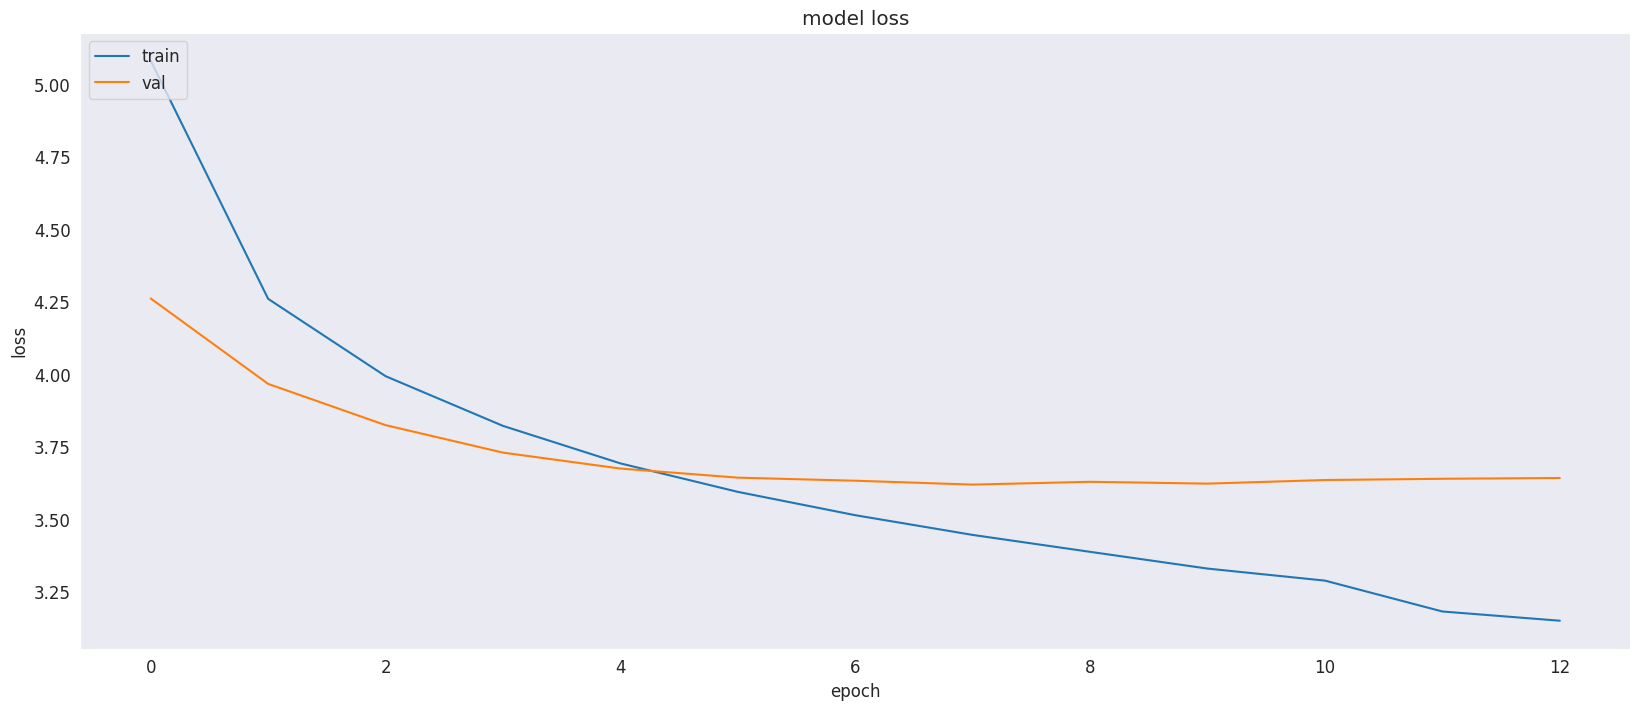

In [12]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

In [22]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "/content/model.keras"
tokenizer_path = "/content/tokenizer.pkl"
feature_extractor_path = "/content/feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=36, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    print(image_features.shape)

    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=34)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()


    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=11, color='black')
    plt.show()

(1, 1920)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


ఎరుపు చొక్కా లో మనిషి రహదారి న బైక్ రైడ్ ఉంది


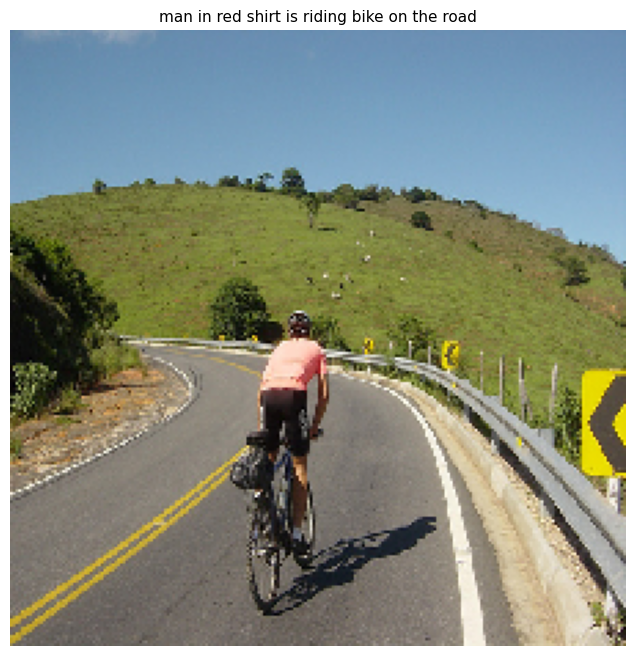

In [23]:
image_path = "/csv_dataset/Images/110595925_f3395c8bd6.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)